## Preprocessing

In [96]:
import os
import json
from collections import defaultdict
from statistics import mean

data_path = 'data'
match_event_counts = defaultdict(int)
first_event_sample = None

# Read JSON files and collect event counts
for filename in os.listdir(data_path):
    if filename.endswith('.json') and filename.startswith('aggregated_'):
        with open(os.path.join(data_path, filename), 'r') as f:
            events = json.load(f)
            if first_event_sample is None and events:
                first_event_sample = events[0]  # For structure printing
            for event in events:
                match_id = event['matchId']
                match_event_counts[match_id] += 1

# Summary statistics
total_matches = len(match_event_counts)
avg_events = mean(match_event_counts.values()) if total_matches > 0 else 0

print(f"Total matches found: {total_matches}")
print(f"Average events per match: {avg_events:.2f}\n")

# Print structure of the first event
def print_json_structure(d, indent=0):
    spacing = '  ' * indent
    if isinstance(d, dict):
        for key, value in d.items():
            print(f"{spacing}{key}:", end=' ')
            if isinstance(value, (dict, list)):
                print()
                print_json_structure(value, indent + 1)
            else:
                print(f"{type(value).__name__}")
    elif isinstance(d, list):
        print(f"{spacing}List of {len(d)} elements:")
        if d:
            print_json_structure(d[0], indent + 1)

print("Structure of a sample event:")
print_json_structure(first_event_sample)


Total matches found: 1941
Average events per match: 1675.06

Structure of a sample event:
eventId: int
subEventName: str
tags: 
  List of 1 elements:
    id: int
playerId: int
positions: 
  List of 2 elements:
    y: int
    x: int
matchId: int
eventName: str
teamId: int
matchPeriod: str
eventSec: float
subEventId: int
id: int
deltaTime: float
dateutc: str
venue: str
role: str
foot: str
height: int
weight: int
age: int


In [97]:
import os
import json
from collections import defaultdict
from statistics import mean

data_path = 'data'
match_event_counts = defaultdict(int)
first_event_sample = None

# Read JSON files and collect event counts
for filename in os.listdir(data_path):
    if filename.endswith('.json') and filename.startswith('aggregated_events_W'):
        with open(os.path.join(data_path, filename), 'r') as f:
            events = json.load(f)
            if first_event_sample is None and events:
                first_event_sample = events[0]  # For structure printing
            for event in events:
                match_id = event['matchId']
                match_event_counts[match_id] += 1

# Summary statistics
total_matches = len(match_event_counts)
avg_events = mean(match_event_counts.values()) if total_matches > 0 else 0

print(f"Total matches found: {total_matches}")
print(f"Average events per match: {avg_events:.2f}\n")

# Print structure of the first event
def print_json_structure(d, indent=0):
    spacing = '  ' * indent
    if isinstance(d, dict):
        for key, value in d.items():
            print(f"{spacing}{key}:", end=' ')
            if isinstance(value, (dict, list)):
                print()
                print_json_structure(value, indent + 1)
            else:
                print(f"{type(value).__name__}")
    elif isinstance(d, list):
        print(f"{spacing}List of {len(d)} elements:")
        if d:
            print_json_structure(d[0], indent + 1)

print("Structure of a sample event:")
print_json_structure(first_event_sample)


Total matches found: 64
Average events per match: 1589.98

Structure of a sample event:
eventId: int
subEventName: str
tags: 
  List of 1 elements:
    id: int
playerId: int
positions: 
  List of 2 elements:
    y: int
    x: int
matchId: int
eventName: str
teamId: int
matchPeriod: str
eventSec: float
subEventId: int
id: int
deltaTime: float
dateutc: str
venue: str
role: str
foot: str
height: int
weight: int
age: int


In [6]:
import os
import json
from datetime import datetime
from collections import defaultdict

DATA_DIR = "data"
OUTPUT_DIR = "data"
PLAYER_FILE = os.path.join(DATA_DIR, "players.json")

# Load player metadata
with open(PLAYER_FILE, 'r') as f:
    players_data = json.load(f)
player_map = {
    p["wyId"]: {
        "role": p.get("role", {}).get("name"),
        "foot": p.get("foot"),
        "height": p.get("height"),
        "weight": p.get("weight"),
        "birthDate": p.get("birthDate")
    }
    for p in players_data
}

# Load match metadata
match_map = {}
for filename in os.listdir(DATA_DIR):
    if filename.startswith("matches_") and filename.endswith(".json"):
        with open(os.path.join(DATA_DIR, filename), 'r') as f:
            matches = json.load(f)
            for match in matches:
                match_id = match["wyId"]
                match_map[match_id] = {
                    "dateutc": match["dateutc"],
                    "venue": match["venue"]
                }

# Helper to calculate age at match time
def calculate_age(birth_date_str, match_date_str):
    if not birth_date_str or not match_date_str:
        return None
    birth_date = datetime.strptime(birth_date_str, "%Y-%m-%d")
    match_date = datetime.strptime(match_date_str, "%Y-%m-%d %H:%M:%S")
    return match_date.year - birth_date.year - ((match_date.month, match_date.day) < (birth_date.month, birth_date.day))

# Process event files
for filename in os.listdir(DATA_DIR):
    if filename.startswith("events_") and filename.endswith(".json"):
        with open(os.path.join(DATA_DIR, filename), 'r') as f:
            events = json.load(f)

        # Sort by match and time for deltaTime computation
        events.sort(key=lambda e: (e["matchId"], e["eventSec"]))

        last_event_time = defaultdict(lambda: 0.0)
        enriched_events = []

        for event in events:
            match_id = event["matchId"]
            player_id = event["playerId"]
            event_time = event["eventSec"]

            # deltaTime
            delta = event_time - last_event_time[match_id]
            last_event_time[match_id] = event_time
            event["deltaTime"] = round(delta, 3)

            # match metadata
            match_info = match_map.get(match_id, {})
            event["dateutc"] = match_info.get("dateutc")
            event["venue"] = match_info.get("venue")

            # player metadata
            player_info = player_map.get(player_id, {})
            event["role"] = player_info.get("role")
            event["foot"] = player_info.get("foot")
            event["height"] = player_info.get("height")
            event["weight"] = player_info.get("weight")
            event["age"] = calculate_age(player_info.get("birthDate"), match_info.get("dateutc"))

            enriched_events.append(event)

        # Write to new file
        output_file = os.path.join(OUTPUT_DIR, f"aggregated_{filename}")
        with open(output_file, 'w') as f:
            json.dump(enriched_events, f)

        print(f"Saved: {output_file}")


Saved: data\aggregated_events_England.json
Saved: data\aggregated_events_European_Championship.json
Saved: data\aggregated_events_France.json
Saved: data\aggregated_events_Germany.json
Saved: data\aggregated_events_Italy.json
Saved: data\aggregated_events_Spain.json
Saved: data\aggregated_events_World_Cup.json


In [ ]:
import os
import json
from datetime import datetime
from collections import defaultdict

DATA_DIR = "data"
OUTPUT_DIR = "data"
PLAYER_FILE = os.path.join(DATA_DIR, "players.json")

# Load player metadata
with open(PLAYER_FILE, 'r') as f:
    players_data = json.load(f)
player_map = {
    p["wyId"]: {
        "role": p.get("role", {}).get("name"),
        "foot": p.get("foot"),
        "height": p.get("height"),
        "weight": p.get("weight"),
        "birthDate": p.get("birthDate")
    }
    for p in players_data
}

# Load match metadata
match_map = {}
for filename in os.listdir(DATA_DIR):
    if filename.startswith("matches_") and filename.endswith(".json"):
        with open(os.path.join(DATA_DIR, filename), 'r') as f:
            matches = json.load(f)
            for match in matches:
                match_id = match["wyId"]
                match_map[match_id] = {
                    "dateutc": match["dateutc"],
                    "venue": match["venue"]
                }

# Helper to calculate age at match time
def calculate_age(birth_date_str, match_date_str):
    if not birth_date_str or not match_date_str:
        return None
    birth_date = datetime.strptime(birth_date_str, "%Y-%m-%d")
    match_date = datetime.strptime(match_date_str, "%Y-%m-%d %H:%M:%S")
    return match_date.year - birth_date.year - ((match_date.month, match_date.day) < (birth_date.month, birth_date.day))

# Process event files
for filename in os.listdir(DATA_DIR):
    if filename.startswith("events_") and filename.endswith(".json"):
        with open(os.path.join(DATA_DIR, filename), 'r') as f:
            events = json.load(f)

        # Sort by match and time for deltaTime computation
        events.sort(key=lambda e: (e["matchId"], e["eventSec"]))

        last_event_time = defaultdict(lambda: 0.0)
        enriched_events = []

        for event in events:
            match_id = event["matchId"]
            player_id = event["playerId"]
            event_time = event["eventSec"]

            # deltaTime
            delta = event_time - last_event_time[match_id]
            last_event_time[match_id] = event_time
            event["deltaTime"] = round(delta, 3)

            # match metadata
            match_info = match_map.get(match_id, {})
            event["dateutc"] = match_info.get("dateutc")
            event["venue"] = match_info.get("venue")

            # player metadata
            player_info = player_map.get(player_id, {})
            event["role"] = player_info.get("role")
            event["foot"] = player_info.get("foot")
            event["height"] = player_info.get("height")
            event["weight"] = player_info.get("weight")
            event["age"] = calculate_age(player_info.get("birthDate"), match_info.get("dateutc"))

            enriched_events.append(event)

        # Write to new file
        output_file = os.path.join(OUTPUT_DIR, f"aggregated_{filename}")
        with open(output_file, 'w') as f:
            json.dump(enriched_events, f)

        print(f"Saved: {output_file}")


In [10]:
import os
import json

DATA_DIR = "data/training"
total_delta = 0.0
delta_count = 0

for filename in os.listdir(DATA_DIR):
    if filename.startswith("aggregated_") and filename.endswith(".json"):
        with open(os.path.join(DATA_DIR, filename), 'r') as f:
            events = json.load(f)
            for event in events:
                delta = event.get("deltaTime")
                if delta is not None:
                    total_delta += delta
                    delta_count += 1

if delta_count > 0:
    average_delta = total_delta / delta_count
    print(f"Average deltaTime across all matches: {average_delta:.3f} seconds")
else:
    print("No deltaTime values found.")


Average deltaTime across all matches: 1.745 seconds


In [13]:
import os
import json

# ===== Configurable Parameters =====
DATA_DIR = "data"
OUTPUT_DIR = "data"
N_PREVIOUS_EVENTS = 99  # Number of context events before the target
PASS_EVENT_ID = 8
SHOT_EVENT_ID = 10
MIN_PASS_GAP = 40 # Minimum index gap to reduce overlap (for passes only)
# ===================================

total_passes = 0
total_shots = 0

for filename in os.listdir(DATA_DIR):
    if filename.startswith("aggregated_") and filename.endswith(".json"):
        with open(os.path.join(DATA_DIR, filename), 'r') as f:
            events = json.load(f)

        leading_examples = []
        used_pass_indices = set()
        file_passes = 0
        file_shots = 0

        for i in range(N_PREVIOUS_EVENTS, len(events)):
            window = events[i - N_PREVIOUS_EVENTS:i + 1]
            last_event = window[-1]

            if last_event["eventId"] == PASS_EVENT_ID:
                if any(abs(i - idx) < MIN_PASS_GAP for idx in used_pass_indices):
                    continue
                used_pass_indices.add(i)
                file_passes += 1

            elif last_event["eventId"] == SHOT_EVENT_ID:
                file_shots += 1

            else:
                continue  # Skip non-pass, non-shot events

            leading_examples.append(window)

        total_passes += file_passes
        total_shots += file_shots

        out_filename = os.path.join(
            OUTPUT_DIR,
            filename.replace("aggregated_", "leading_")
        )
        with open(out_filename, 'w') as f:
            json.dump(leading_examples, f)

        print(f"{filename}: {file_passes} passes, {file_shots} shots saved")

print(f"\nTOTAL: {total_passes} passes, {total_shots} shots saved across all files")


aggregated_events_England.json: 15527 passes, 8450 shots saved
aggregated_events_European_Championship.json: 1898 passes, 1194 shots saved
aggregated_events_France.json: 15271 passes, 8326 shots saved
aggregated_events_Germany.json: 12539 passes, 6897 shots saved
aggregated_events_Italy.json: 15676 passes, 8806 shots saved
aggregated_events_Spain.json: 15178 passes, 7977 shots saved
aggregated_events_World_Cup.json: 2469 passes, 1419 shots saved

TOTAL: 78558 passes, 43069 shots saved across all files


In [5]:
import torch
import torch.nn as nn

class ShotOutcomePredictor(nn.Module):
    def __init__(self, input_size=28, hidden_size=64, num_classes=4):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        h = torch.cat((h_n[0], h_n[1]), dim=1)  # forward and backward
        return self.classifier(h)


In [ ]:
from torch.utils.data import Dataset
import json
import torch

class ShotDataset(Dataset):
    def __init__(self, file_paths, input_dim=28, device='cuda'):
        self.samples = []
        self.input_dim = input_dim
        self.device = device
        for path in file_paths:
            with open(path, 'r') as f:
                self.samples.extend(json.load(f))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        x = torch.rand(99, self.input_dim, device=self.device)  # Dummy feature vector
        tags = {tag["id"] for tag in sample[-1].get("tags", [])}
        if 101 in tags:
            label = 0  # goal
        elif 121 in tags:
            label = 1  # saved
        elif 2101 in tags:
            label = 2  # blocked
        else:
            label = 3  # off target
        return x, torch.tensor(label, device=self.device)


In [ ]:
import os
import json
import torch
from tqdm import tqdm

def save_shot_tensor_dataset(json_files, output_path, input_dim=28, device='cuda'):
    features = []
    labels = []

    for file_path in tqdm(json_files, desc=f"Processing {os.path.basename(output_path)}"):
        with open(file_path, 'r') as f:
            samples = json.load(f)
            for sample in samples:
                # === Replace this with real feature extraction later ===
                x = torch.rand(99, input_dim, device=device)

                # Shot outcome label
                tags = {tag["id"] for tag in sample[-1].get("tags", [])}
                if 101 in tags:
                    label = 0  # goal
                elif 121 in tags:
                    label = 1  # saved
                elif 2101 in tags:
                    label = 2  # blocked
                else:
                    label = 3  # off target

                features.append(x)
                labels.append(torch.tensor(label, device=device))

    # Stack and save
    X = torch.stack(features)
    y = torch.tensor(labels, device=device)
    torch.save((X, y), output_path)
    print(f"Saved {X.shape[0]} samples to {output_path}")


[Epoch 1] Train Loss: 0.4920
Val Accuracy: 0.8785
[Epoch 2] Train Loss: 0.4835
Val Accuracy: 0.8785

⏱️ Total training time: 85.38 seconds


In [ ]:
import os
import json
import torch
from tqdm import tqdm
import torch

# Define categorical mappings
foot_map = {"left": 0, "right": 1, "both": 2}
role_map = {"Goalkeeper": 0, "Defender": 1, "Midfielder": 2, "Forward": 3}  # Add more if needed
period_map = {"1H": 0, "2H": 1, "E1": 2, "E2": 3, "P": 4}

def extract_event_features(event, input_dim=28):
    # === Numeric Features ===
    delta = (event.get("deltaTime") or 0) / 10
    event_sec = (event.get("eventSec") or 0) / 3000
    positions = event.get("positions", [{}])
    x0 = positions[0].get("x", 0) / 100
    y0 = positions[0].get("y", 0) / 100
    x1 = positions[-1].get("x", 0) / 100
    y1 = positions[-1].get("y", 0) / 100
    height = (event.get("height") or 180) / 200
    weight = (event.get("weight") or 75) / 120
    age = (event.get("age") or 25) / 40

    float_features = [delta, event_sec, x0, y0, x1, y1, height, weight, age]

    # === Categorical Features (one-hot) ===
    foot_map = {"left": 0, "right": 1, "both": 2}
    foot = (event.get("foot") or "right").lower()
    foot_vec = [0, 0, 0]
    foot_vec[foot_map.get(foot, 1)] = 1

    role_map = {
        "Goalkeeper": 0, "Defender": 1,
        "Midfielder": 2, "Forward": 3
    }
    role_raw = event.get("role", "Midfielder")
    if isinstance(role_raw, dict):
        role_name = role_raw.get("name", "Midfielder")
    else:
        role_name = role_raw or "Midfielder"

    role_vec = [0] * len(role_map)
    role_vec[role_map.get(role_name, 2)] = 1

    period_map = {"1H": 0, "2H": 1, "E1": 2, "E2": 3, "P": 4}
    period = event.get("matchPeriod", "1H")
    period_vec = [0] * len(period_map)
    period_vec[period_map.get(period, 0)] = 1

    # === Event IDs (scaled or embedded later) ===
    event_id = int(event.get("eventId") or 0)
    sub_event_id = int(event.get("subEventId") or 0)
    embedded = [event_id / 10, sub_event_id / 100]

    # === Combine Everything ===
    full_vec = float_features + foot_vec + role_vec + period_vec + embedded
    return torch.tensor(full_vec[:input_dim], dtype=torch.float32)



def save_shot_tensor_dataset(json_files, output_path, input_dim=28, device='cuda'):
    features = []
    labels = []

    for file_path in tqdm(json_files, desc=f"Processing {os.path.basename(output_path)}"):
        with open(file_path, 'r') as f:
            samples = json.load(f)
            for sample in samples:
                # Extract features for each of the 99 events in the window
                event_features = [extract_event_features(ev, input_dim) for ev in sample[:-1]]
                x = torch.stack(event_features).to(device)  # Shape: [99, input_dim]

                # Shot outcome label (based on final event)
                tags = {tag["id"] for tag in sample[-1].get("tags", [])}
                if 101 in tags:
                    label = 0  # goal
                elif 121 in tags:
                    label = 1  # saved
                elif 2101 in tags:
                    label = 2  # blocked
                else:
                    label = 3  # off target

                features.append(x)
                labels.append(torch.tensor(label, device=device))
    

def save_pass_tensor_dataset(json_files, output_path, input_dim=28, device='cuda'):
    features = []
    labels = []

    for file_path in tqdm(json_files, desc=f"Processing {os.path.basename(output_path)}"):
        with open(file_path, 'r') as f:
            samples = json.load(f)
            for sample in samples:
                last_event = sample[-1]

                # Only include passes
                if last_event.get("eventName") != "Pass":
                    continue

                tag_ids = {tag["id"] for tag in last_event.get("tags", [])}
                label = 1 if 1801 in tag_ids else 0  # Successful pass

                try:
                    event_features = [extract_event_features(ev, input_dim) for ev in sample[:-1]]
                    x = torch.stack(event_features).to(device)
                    features.append(x)
                    labels.append(torch.tensor(label, device=device))
                except Exception as e:
                    print(f"Skipping corrupt sample: {e}")
                    continue


    X = torch.stack(features)
    y = torch.tensor(labels, device=device)
    torch.save((X, y), output_path)
    print(f"Saved {X.shape[0]} samples to {output_path}")


In [5]:
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
input_dim = 28  # You can adjust if using real features later

# TRAINING FILES
train_dir = "data/training"
train_files = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.startswith("leading_")]
random.shuffle(train_files)  # optional
save_pass_tensor_dataset(train_files, "train_passes.pt", input_dim=input_dim, device=device)

# TEST FILES
test_dir = "data/test"
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.startswith("leading_")]
save_pass_tensor_dataset(test_files, "test_passes.pt", input_dim=input_dim, device=device)


Using device: cuda


Processing train_passes.pt: 100%|██████████| 6/6 [06:10<00:00, 61.73s/it]


Saved 76089 samples to train_passes.pt


Processing test_passes.pt: 100%|██████████| 1/1 [00:07<00:00,  7.17s/it]


Saved 2469 samples to test_passes.pt


## GRU Model

Using device: cuda
Balanced dataset → Successes: 4363, Failures: 87260
[Epoch 1] Train Loss: 1.2386 | Train Acc: 0.6015 | Val Loss: 1.1711 | Val Acc: 0.5479
[Epoch 2] Train Loss: 1.1097 | Train Acc: 0.6261 | Val Loss: 1.0438 | Val Acc: 0.6055
[Epoch 3] Train Loss: 1.0586 | Train Acc: 0.6447 | Val Loss: 1.0910 | Val Acc: 0.5531
[Epoch 4] Train Loss: 1.0246 | Train Acc: 0.6559 | Val Loss: 0.9789 | Val Acc: 0.6897
[Epoch 5] Train Loss: 0.9911 | Train Acc: 0.6806 | Val Loss: 0.9375 | Val Acc: 0.7647
[Epoch 6] Train Loss: 0.9684 | Train Acc: 0.7020 | Val Loss: 0.9048 | Val Acc: 0.7199
[Epoch 7] Train Loss: 0.9468 | Train Acc: 0.7054 | Val Loss: 0.9600 | Val Acc: 0.7847
[Epoch 8] Train Loss: 0.9320 | Train Acc: 0.7134 | Val Loss: 0.8880 | Val Acc: 0.7106
[Epoch 9] Train Loss: 0.9254 | Train Acc: 0.7151 | Val Loss: 0.9202 | Val Acc: 0.7473
[Epoch 10] Train Loss: 0.9135 | Train Acc: 0.7177 | Val Loss: 0.8811 | Val Acc: 0.7641
[Epoch 11] Train Loss: 0.9103 | Train Acc: 0.7199 | Val Loss: 0.8824

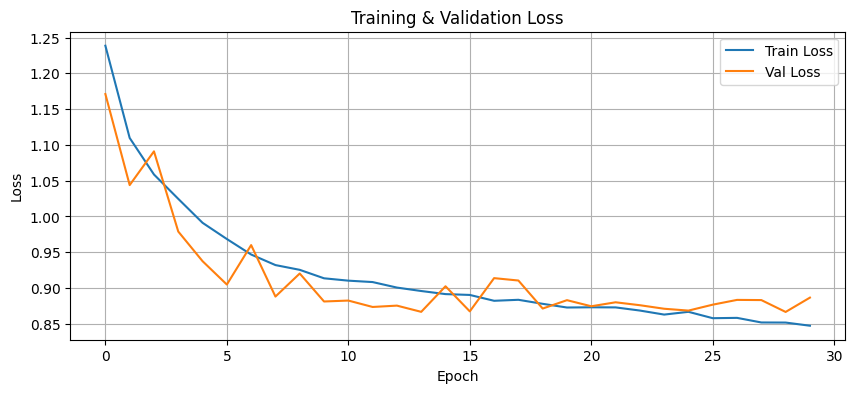

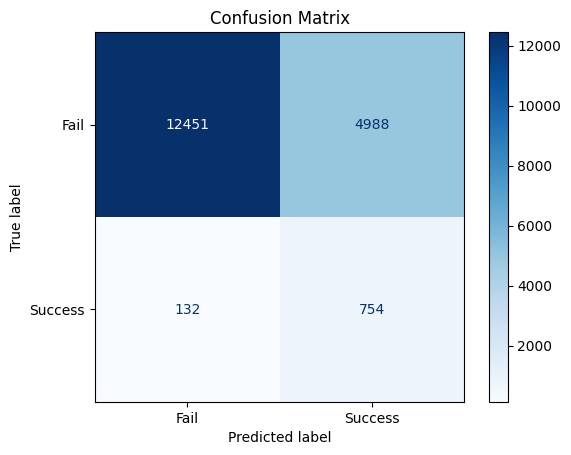

Precision: 0.1313
Recall:    0.8510
F1 Score:  0.2275


In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import time
import numpy as np

# Confirm GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Load and Balance Dataset ===
X, y = torch.load("train_shots.pt", map_location="cpu")
X = X[:, -29:, :]

# y = y.long()
y_binary = (y == 0).long()  # Goal = success (1), others = fail (0)


# success_indices = (y == 1).nonzero(as_tuple=True)[0]
# fail_indices = (y == 0).nonzero(as_tuple=True)[0]
success_indices = (y_binary == 1).nonzero(as_tuple=True)[0]
fail_indices = (y_binary == 0).nonzero(as_tuple=True)[0]


# balanced_success_indices = success_indices[torch.randperm(len(success_indices))[:len(fail_indices)]]
num_success = len(success_indices)
fail_sample_size = min(len(fail_indices), num_success * 20)
balanced_fail_indices = fail_indices[torch.randperm(len(fail_indices))[:fail_sample_size]]
# balanced_indices = torch.cat([balanced_success_indices, fail_indices])
balanced_indices = torch.cat([success_indices, balanced_fail_indices])
shuffled = balanced_indices[torch.randperm(len(balanced_indices))]

X_balanced = X[shuffled]
y_balanced = y_binary[shuffled]

print(f"Balanced dataset → Successes: {(y_balanced == 1).sum().item()}, Failures: {(y_balanced == 0).sum().item()}")

train_size = int(0.8 * len(X_balanced))
val_size = len(X_balanced) - train_size
train_ds, val_ds = random_split(TensorDataset(X_balanced, y_balanced), [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True, num_workers=6, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=128, pin_memory=True, num_workers=2, persistent_workers=True)

def apply_label_smoothing(y, smoothing=0.1):
    return y * (1.0 - smoothing) + 0.5 * smoothing

# === GRU Model ===
class ShotGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        _, h_n = self.gru(x)  # h_n: [num_layers * 2, batch, hidden_dim]
        h_fwd = h_n[-2]       # Last layer forward
        h_bwd = h_n[-1]       # Last layer backward
        h = torch.cat((h_fwd, h_bwd), dim=1)  # [batch, hidden_dim * 2]
        return self.classifier(h).squeeze(1)

# === Training Setup ===
model = ShotGRU(input_dim=X.shape[2]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=3e-4)
# Compute dynamic weight

pos_weight_value = len(balanced_fail_indices) / len(success_indices)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], device=device))

num_epochs = 30
train_losses, val_losses, val_accuracies = [], [], []
start_time = time.time()

# === Training Loop ===
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    train_correct, train_total = 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).float()
        optimizer.zero_grad()
        output = model(xb)

        smoothed_yb = apply_label_smoothing(yb, smoothing=0.002)
        loss = criterion(output, smoothed_yb)

        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

        preds = (torch.sigmoid(output) > 0.5).long()
        train_correct += (preds == yb.long()).sum().item()
        train_total += yb.size(0)

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_acc = train_correct / train_total
    train_losses.append(avg_train_loss)


    # === Validation ===
    model.eval()
    val_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device).float()
            output = model(xb)
            loss = criterion(output, yb)

            val_loss += loss.item()

            preds = (torch.sigmoid(output) > 0.5).long()
            correct += (preds == yb.long()).sum().item()
            total += yb.size(0)
            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

# === Final Metrics ===
total_time = time.time() - start_time
final_val_acc = val_accuracies[-1]
print(f"\nFinal Validation Accuracy: {final_val_acc:.4f}")
print(f"Total Training Time: {total_time:.2f} seconds")

# === Plot Losses ===
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fail", "Success"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



In [76]:
import torch
import numpy as np
from copy import deepcopy
from tqdm import tqdm

def compute_permutation_importance(model, val_loader, baseline_acc, device, feature_names=None):
    model.eval()
    model.to(device)

    input_dim = next(iter(val_loader))[0].shape[2]
    importances = []

    for feature_idx in tqdm(range(input_dim), desc="Evaluating feature importance"):
        correct, total = 0, 0

        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb_shuffled = xb.clone()

            # Shuffle this feature across the batch and sequence
            perm = torch.randperm(xb.size(0))
            xb_shuffled[:, :, feature_idx] = xb[perm, :, feature_idx]

            with torch.no_grad():
                preds = (torch.sigmoid(model(xb_shuffled)) > 0.5).long()
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        shuffled_acc = correct / total
        drop = baseline_acc - shuffled_acc
        importances.append(drop)

    # Rank results
    feature_names = feature_names if feature_names else [f"f{i}" for i in range(input_dim)]
    feature_ranking = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

    # Display
    print("\nFeature Importance (by drop in accuracy):")
    for name, drop in feature_ranking:
        print(f"{name:<20} Drop: {drop:.4f}")

    return feature_ranking

# Measure baseline accuracy first
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = (torch.sigmoid(model(xb)) > 0.5).long()
        correct += (preds == yb).sum().item()
        total += yb.size(0)
baseline_accuracy = correct / total

feature_names = [
    "delta", "event_sec", "x0", "y0", "x1", "y1", 
    "plr_height", "plr_weight", "plr_age",
    "foot_left", "foot_right", "foot_unknown",
    "role_gk", "role_def", "role_mid", "role_fwd",
    "period_1H", "period_2H", "period_E1", "period_E2", "period_P",
    "event_id", "subevent_id"
]  # Add more if you're using more

# Run permutation importance
ranking = compute_permutation_importance(model, val_loader, baseline_accuracy, device, feature_names)


Evaluating feature importance: 100%|██████████| 23/23 [00:11<00:00,  1.94it/s]


Feature Importance (by drop in accuracy):
x1                   Drop: 0.0169
x0                   Drop: 0.0139
role_fwd             Drop: 0.0114
y0                   Drop: 0.0110
foot_left            Drop: 0.0093
role_mid             Drop: 0.0081
y1                   Drop: 0.0068
period_2H            Drop: 0.0026
plr_weight           Drop: 0.0002
foot_unknown         Drop: 0.0002
period_E1            Drop: 0.0001
period_E2            Drop: 0.0001
foot_right           Drop: 0.0000
period_P             Drop: 0.0000
plr_age              Drop: -0.0002
plr_height           Drop: -0.0007
period_1H            Drop: -0.0008
event_sec            Drop: -0.0009
event_id             Drop: -0.0037
subevent_id          Drop: -0.0040
role_gk              Drop: -0.0088
delta                Drop: -0.0095
role_def             Drop: -0.0135



Evaluating on test set...
Test Accuracy: 0.7099


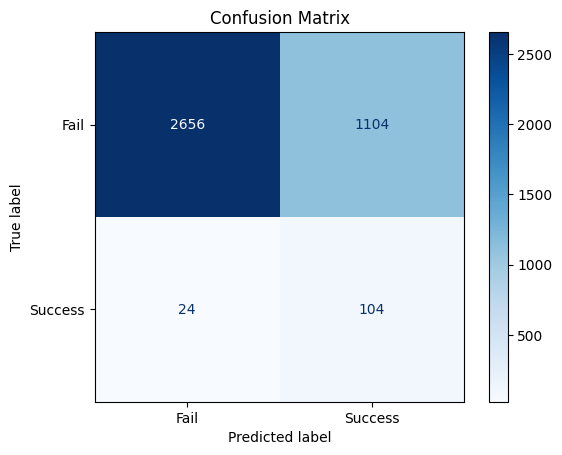

Precision: 0.0861
Recall:    0.8125
F1 Score:  0.1557


In [77]:
# === Test Evaluation ===
print("\nEvaluating on test set...")

# Load test data
X_test, y_test = torch.load("test_shots.pt", map_location="cpu")
X_test = X_test[:, -29:, :]
y_test_binary = (y_test == 0).long()  # goal → 1, others → 0

# Forward pass
model.eval()
all_test_preds = []
with torch.no_grad():
    for i in range(0, len(X_test), 128):
        xb = X_test[i:i+128].to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long().cpu()
        all_test_preds.extend(preds)

# Compute accuracy
y_test_binary = y_test_binary[:len(all_test_preds)]  # just in case
correct = (torch.tensor(all_test_preds) == y_test_binary).sum().item()
total = len(y_test_binary)
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_test_binary, all_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fail", "Success"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

precision = precision_score(y_test_binary, all_test_preds)
recall = recall_score(y_test_binary, all_test_preds)
f1 = f1_score(y_test_binary, all_test_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



## GRU With Attention

Using device: cuda
Balanced dataset → Successes: 4363, Failures: 87260
[Epoch 1] Train Loss: 1.2392 | Train Acc: 0.5952 | Val Loss: 1.1616 | Val Acc: 0.4998
[Epoch 2] Train Loss: 1.0943 | Train Acc: 0.6294 | Val Loss: 1.0638 | Val Acc: 0.7773
[Epoch 3] Train Loss: 1.0444 | Train Acc: 0.6519 | Val Loss: 0.9972 | Val Acc: 0.6696
[Epoch 4] Train Loss: 1.0064 | Train Acc: 0.6799 | Val Loss: 0.9475 | Val Acc: 0.6601
[Epoch 5] Train Loss: 0.9662 | Train Acc: 0.7032 | Val Loss: 0.9318 | Val Acc: 0.6530
[Epoch 6] Train Loss: 0.9480 | Train Acc: 0.7070 | Val Loss: 0.9139 | Val Acc: 0.7341
[Epoch 7] Train Loss: 0.9345 | Train Acc: 0.7130 | Val Loss: 0.9231 | Val Acc: 0.6805
[Epoch 8] Train Loss: 0.9217 | Train Acc: 0.7143 | Val Loss: 0.8968 | Val Acc: 0.6913
[Epoch 9] Train Loss: 0.9164 | Train Acc: 0.7188 | Val Loss: 0.8923 | Val Acc: 0.7042
[Epoch 10] Train Loss: 0.9117 | Train Acc: 0.7153 | Val Loss: 0.8836 | Val Acc: 0.7024
[Epoch 11] Train Loss: 0.9105 | Train Acc: 0.7162 | Val Loss: 0.8744

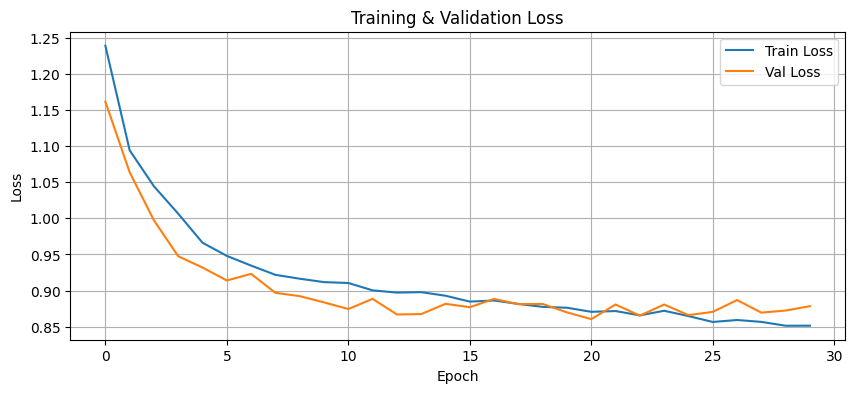

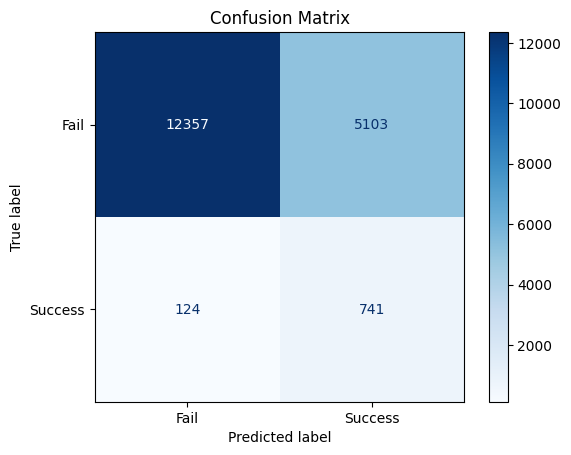

Precision: 0.1268
Recall:    0.8566
F1 Score:  0.2209


In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import time
import numpy as np

# Confirm GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Load and Balance Dataset ===
X, y = torch.load("train_shots.pt", map_location="cpu")
X = X[:, -29:, :]

# y = y.long()
y_binary = (y == 0).long()  # Goal = success (1), others = fail (0)


# success_indices = (y == 1).nonzero(as_tuple=True)[0]
# fail_indices = (y == 0).nonzero(as_tuple=True)[0]
success_indices = (y_binary == 1).nonzero(as_tuple=True)[0]
fail_indices = (y_binary == 0).nonzero(as_tuple=True)[0]


# balanced_success_indices = success_indices[torch.randperm(len(success_indices))[:len(fail_indices)]]
num_success = len(success_indices)
fail_sample_size = min(len(fail_indices), num_success * 20)
balanced_fail_indices = fail_indices[torch.randperm(len(fail_indices))[:fail_sample_size]]
# balanced_indices = torch.cat([balanced_success_indices, fail_indices])
balanced_indices = torch.cat([success_indices, balanced_fail_indices])
shuffled = balanced_indices[torch.randperm(len(balanced_indices))]

X_balanced = X[shuffled]
y_balanced = y_binary[shuffled]

print(f"Balanced dataset → Successes: {(y_balanced == 1).sum().item()}, Failures: {(y_balanced == 0).sum().item()}")

train_size = int(0.8 * len(X_balanced))
val_size = len(X_balanced) - train_size
train_ds, val_ds = random_split(TensorDataset(X_balanced, y_balanced), [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True, num_workers=6, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=128, pin_memory=True, num_workers=2, persistent_workers=True)

def apply_label_smoothing(y, smoothing=0.1):
    return y * (1.0 - smoothing) + 0.5 * smoothing

# === GRU Model ===
class ShotGRUWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        self.attn = nn.Linear(hidden_dim * 2, 1)  # attention over time

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        gru_out, _ = self.gru(x)  # [batch, seq_len, hidden*2]

        # Attention weights
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)  # [batch, seq_len, 1]
        weighted = (gru_out * attn_weights).sum(dim=1)           # [batch, hidden*2]

        return self.classifier(weighted).squeeze(1)

# === Training Setup ===
model = ShotGRU(input_dim=X.shape[2]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=3e-4)
# Compute dynamic weight

pos_weight_value = len(balanced_fail_indices) / len(success_indices)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], device=device))

num_epochs = 30
train_losses, val_losses, val_accuracies = [], [], []
start_time = time.time()

# === Training Loop ===
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    train_correct, train_total = 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).float()
        optimizer.zero_grad()
        output = model(xb)

        smoothed_yb = apply_label_smoothing(yb, smoothing=0.002)
        loss = criterion(output, smoothed_yb)

        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

        preds = (torch.sigmoid(output) > 0.5).long()
        train_correct += (preds == yb.long()).sum().item()
        train_total += yb.size(0)

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_acc = train_correct / train_total
    train_losses.append(avg_train_loss)


    # === Validation ===
    model.eval()
    val_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device).float()
            output = model(xb)
            loss = criterion(output, yb)

            val_loss += loss.item()

            preds = (torch.sigmoid(output) > 0.5).long()
            correct += (preds == yb.long()).sum().item()
            total += yb.size(0)
            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

# === Final Metrics ===
total_time = time.time() - start_time
final_val_acc = val_accuracies[-1]
print(f"\nFinal Validation Accuracy: {final_val_acc:.4f}")
print(f"Total Training Time: {total_time:.2f} seconds")

# === Plot Losses ===
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fail", "Success"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



In [79]:
import torch
import numpy as np
from copy import deepcopy
from tqdm import tqdm

def compute_permutation_importance(model, val_loader, baseline_acc, device, feature_names=None):
    model.eval()
    model.to(device)

    input_dim = next(iter(val_loader))[0].shape[2]
    importances = []

    for feature_idx in tqdm(range(input_dim), desc="Evaluating feature importance"):
        correct, total = 0, 0

        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb_shuffled = xb.clone()

            # Shuffle this feature across the batch and sequence
            perm = torch.randperm(xb.size(0))
            xb_shuffled[:, :, feature_idx] = xb[perm, :, feature_idx]

            with torch.no_grad():
                preds = (torch.sigmoid(model(xb_shuffled)) > 0.5).long()
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        shuffled_acc = correct / total
        drop = baseline_acc - shuffled_acc
        importances.append(drop)

    # Rank results
    feature_names = feature_names if feature_names else [f"f{i}" for i in range(input_dim)]
    feature_ranking = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

    # Display
    print("\nFeature Importance (by drop in accuracy):")
    for name, drop in feature_ranking:
        print(f"{name:<20} Drop: {drop:.4f}")

    return feature_ranking

# Measure baseline accuracy first
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = (torch.sigmoid(model(xb)) > 0.5).long()
        correct += (preds == yb).sum().item()
        total += yb.size(0)
baseline_accuracy = correct / total

feature_names = [
    "delta", "event_sec", "x0", "y0", "x1", "y1", 
    "plr_height", "plr_weight", "plr_age",
    "foot_left", "foot_right", "foot_unknown",
    "role_gk", "role_def", "role_mid", "role_fwd",
    "period_1H", "period_2H", "period_E1", "period_E2", "period_P",
    "event_id", "subevent_id"
]  # Add more if you're using more

# Run permutation importance
ranking = compute_permutation_importance(model, val_loader, baseline_accuracy, device, feature_names)


Evaluating feature importance: 100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


Feature Importance (by drop in accuracy):
x0                   Drop: 0.0404
x1                   Drop: 0.0390
foot_left            Drop: 0.0153
y0                   Drop: 0.0118
role_fwd             Drop: 0.0117
y1                   Drop: 0.0095
period_2H            Drop: 0.0080
foot_right           Drop: 0.0045
role_mid             Drop: 0.0041
plr_age              Drop: 0.0001
period_E2            Drop: 0.0001
foot_unknown         Drop: 0.0001
period_1H            Drop: 0.0001
period_E1            Drop: 0.0001
period_P             Drop: 0.0000
event_sec            Drop: -0.0001
plr_weight           Drop: -0.0003
plr_height           Drop: -0.0016
delta                Drop: -0.0034
event_id             Drop: -0.0042
role_gk              Drop: -0.0065
subevent_id          Drop: -0.0066
role_def             Drop: -0.0166



Evaluating on test set...
Test Accuracy: 0.6993


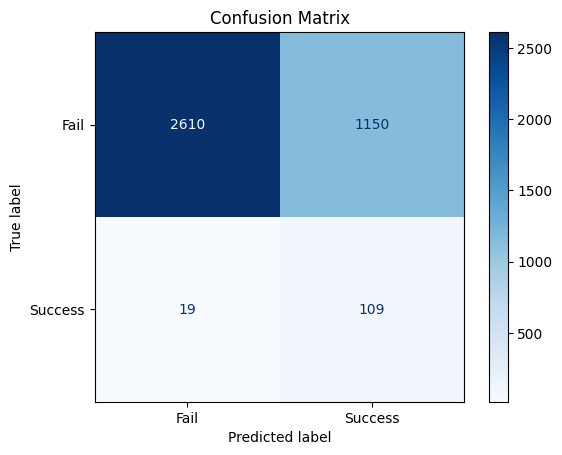

Precision: 0.0866
Recall:    0.8516
F1 Score:  0.1572


In [81]:
# === Test Evaluation ===
print("\nEvaluating on test set...")

# Load test data
X_test, y_test = torch.load("test_shots.pt", map_location="cpu")
X_test = X_test[:, -29:, :]
y_test_binary = (y_test == 0).long()  # goal → 1, others → 0

# Forward pass
model.eval()
all_test_preds = []
with torch.no_grad():
    for i in range(0, len(X_test), 128):
        xb = X_test[i:i+128].to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long().cpu()
        all_test_preds.extend(preds)

# Compute accuracy
y_test_binary = y_test_binary[:len(all_test_preds)]  # just in case
correct = (torch.tensor(all_test_preds) == y_test_binary).sum().item()
total = len(y_test_binary)
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_test_binary, all_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fail", "Success"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

precision = precision_score(y_test_binary, all_test_preds)
recall = recall_score(y_test_binary, all_test_preds)
f1 = f1_score(y_test_binary, all_test_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



## Transformer Model

Using device: cuda
Balanced dataset → Successes: 4363, Failures: 87260


c:\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[Epoch 1] Train Loss: 1.3058 | Train Acc: 0.5396 | Val Loss: 1.1463 | Val Acc: 0.7094
[Epoch 2] Train Loss: 1.1997 | Train Acc: 0.6086 | Val Loss: 1.1175 | Val Acc: 0.5237
[Epoch 3] Train Loss: 1.1493 | Train Acc: 0.6206 | Val Loss: 1.0637 | Val Acc: 0.6702
[Epoch 4] Train Loss: 1.1087 | Train Acc: 0.6451 | Val Loss: 1.0460 | Val Acc: 0.5487
[Epoch 5] Train Loss: 1.0766 | Train Acc: 0.6626 | Val Loss: 0.9741 | Val Acc: 0.6556
[Epoch 6] Train Loss: 1.0422 | Train Acc: 0.6711 | Val Loss: 0.9556 | Val Acc: 0.7132
[Epoch 7] Train Loss: 1.0351 | Train Acc: 0.6747 | Val Loss: 0.9532 | Val Acc: 0.7357
[Epoch 8] Train Loss: 1.0232 | Train Acc: 0.6845 | Val Loss: 0.9327 | Val Acc: 0.6632
[Epoch 9] Train Loss: 1.0142 | Train Acc: 0.6815 | Val Loss: 0.9260 | Val Acc: 0.7179
[Epoch 10] Train Loss: 1.0106 | Train Acc: 0.6873 | Val Loss: 0.9262 | Val Acc: 0.6992
[Epoch 11] Train Loss: 0.9986 | Train Acc: 0.6873 | Val Loss: 0.9147 | Val Acc: 0.6887
[Epoch 12] Train Loss: 0.9924 | Train Acc: 0.6875 | 

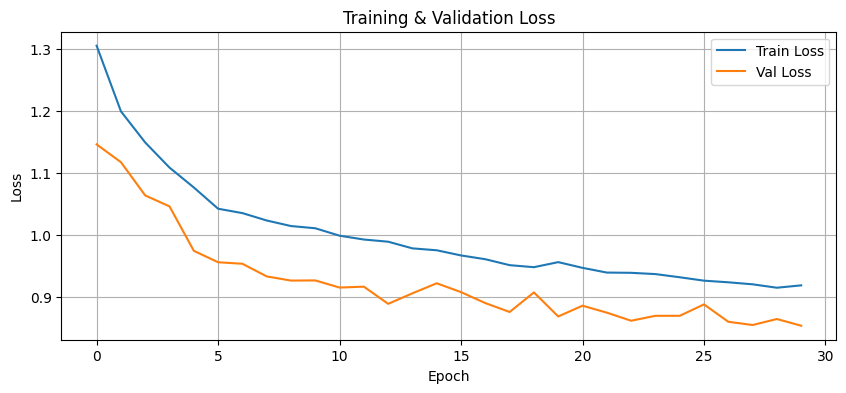

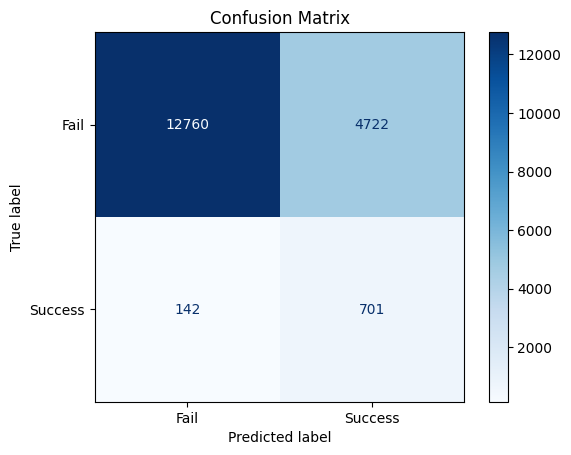

Precision: 0.1293
Recall:    0.8316
F1 Score:  0.2237


In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import time
import numpy as np

# Confirm GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === Load and Balance Dataset ===
X, y = torch.load("train_shots.pt", map_location="cpu")
X = X[:, -29:, :]

# y = y.long()
y_binary = (y == 0).long()  # Goal = success (1), others = fail (0)


# success_indices = (y == 1).nonzero(as_tuple=True)[0]
# fail_indices = (y == 0).nonzero(as_tuple=True)[0]
success_indices = (y_binary == 1).nonzero(as_tuple=True)[0]
fail_indices = (y_binary == 0).nonzero(as_tuple=True)[0]


# balanced_success_indices = success_indices[torch.randperm(len(success_indices))[:len(fail_indices)]]
num_success = len(success_indices)
fail_sample_size = min(len(fail_indices), num_success * 20)
balanced_fail_indices = fail_indices[torch.randperm(len(fail_indices))[:fail_sample_size]]
# balanced_indices = torch.cat([balanced_success_indices, fail_indices])
balanced_indices = torch.cat([success_indices, balanced_fail_indices])
shuffled = balanced_indices[torch.randperm(len(balanced_indices))]

X_balanced = X[shuffled]
y_balanced = y_binary[shuffled]

print(f"Balanced dataset → Successes: {(y_balanced == 1).sum().item()}, Failures: {(y_balanced == 0).sum().item()}")

train_size = int(0.8 * len(X_balanced))
val_size = len(X_balanced) - train_size
train_ds, val_ds = random_split(TensorDataset(X_balanced, y_balanced), [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True, num_workers=6, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=128, pin_memory=True, num_workers=2, persistent_workers=True)

def apply_label_smoothing(y, smoothing=0.1):
    return y * (1.0 - smoothing) + 0.5 * smoothing

# === Transformer Model ===
class ShotTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_heads=4, num_layers=2, dropout=0.2):
        super().__init__()
        self.max_seq_len = 29
        self.pos_embed = nn.Parameter(torch.randn(1, self.max_seq_len, input_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pos_embed[:, :seq_len, :]
        x = self.transformer(x)  # Shape: [batch, seq_len, input_dim]
        x = x.mean(dim=1)        # Global average pooling over time
        return self.classifier(x).squeeze(1)  # Return logits

# === Training Setup ===
model = ShotTransformer(input_dim=X.shape[2], num_heads=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=2e-4)
# Compute dynamic weight

pos_weight_value = len(balanced_fail_indices) / len(success_indices)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], device=device))

num_epochs = 30
train_losses, val_losses, val_accuracies = [], [], []
start_time = time.time()

# === Training Loop ===
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    train_correct, train_total = 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).float()
        optimizer.zero_grad()
        output = model(xb)

        smoothed_yb = apply_label_smoothing(yb, smoothing=0.002)
        loss = criterion(output, smoothed_yb)

        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

        preds = (torch.sigmoid(output) > 0.5).long()
        train_correct += (preds == yb.long()).sum().item()
        train_total += yb.size(0)

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_acc = train_correct / train_total
    train_losses.append(avg_train_loss)


    # === Validation ===
    model.eval()
    val_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device).float()
            output = model(xb)
            loss = criterion(output, yb)

            val_loss += loss.item()

            preds = (torch.sigmoid(output) > 0.5).long()
            correct += (preds == yb.long()).sum().item()
            total += yb.size(0)
            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

# === Final Metrics ===
total_time = time.time() - start_time
final_val_acc = val_accuracies[-1]
print(f"\nFinal Validation Accuracy: {final_val_acc:.4f}")
print(f"Total Training Time: {total_time:.2f} seconds")

# === Plot Losses ===
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fail", "Success"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")



In [89]:
import torch
import numpy as np
from copy import deepcopy
from tqdm import tqdm

def compute_permutation_importance(model, val_loader, baseline_acc, device, feature_names=None):
    model.eval()
    model.to(device)

    input_dim = next(iter(val_loader))[0].shape[2]
    importances = []

    for feature_idx in tqdm(range(input_dim), desc="Evaluating feature importance"):
        correct, total = 0, 0

        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb_shuffled = xb.clone()

            # Shuffle this feature across the batch and sequence
            perm = torch.randperm(xb.size(0))
            xb_shuffled[:, :, feature_idx] = xb[perm, :, feature_idx]

            with torch.no_grad():
                preds = (torch.sigmoid(model(xb_shuffled)) > 0.5).long()
                correct += (preds == yb).sum().item()
                total += yb.size(0)

        shuffled_acc = correct / total
        drop = baseline_acc - shuffled_acc
        importances.append(drop)

    # Rank results
    feature_names = feature_names if feature_names else [f"f{i}" for i in range(input_dim)]
    feature_ranking = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

    # Display
    print("\nFeature Importance (by drop in accuracy):")
    for name, drop in feature_ranking:
        print(f"{name:<20} Drop: {drop:.4f}")

    return feature_ranking

# Measure baseline accuracy first
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = (torch.sigmoid(model(xb)) > 0.5).long()
        correct += (preds == yb).sum().item()
        total += yb.size(0)
baseline_accuracy = correct / total

feature_names = [
    "delta", "event_sec", "x0", "y0", "x1", "y1", 
    "plr_height", "plr_weight", "plr_age",
    "foot_left", "foot_right", "foot_unknown",
    "role_gk", "role_def", "role_mid", "role_fwd",
    "period_1H", "period_2H", "period_E1", "period_E2", "period_P",
    "event_id", "subevent_id"
]  # Add more if you're using more

# Run permutation importance
ranking = compute_permutation_importance(model, val_loader, baseline_accuracy, device, feature_names)


Evaluating feature importance: 100%|██████████| 23/23 [00:17<00:00,  1.35it/s]


Feature Importance (by drop in accuracy):
period_2H            Drop: 0.0904
period_1H            Drop: 0.0792
y0                   Drop: 0.0135
y1                   Drop: 0.0080
role_fwd             Drop: 0.0065
event_id             Drop: 0.0060
delta                Drop: 0.0022
role_gk              Drop: 0.0020
role_mid             Drop: 0.0013
plr_weight           Drop: 0.0012
subevent_id          Drop: 0.0010
event_sec            Drop: 0.0002
foot_unknown         Drop: 0.0001
period_E1            Drop: 0.0001
period_E2            Drop: 0.0000
period_P             Drop: 0.0000
plr_height           Drop: -0.0013
plr_age              Drop: -0.0021
foot_left            Drop: -0.0068
role_def             Drop: -0.0120
foot_right           Drop: -0.0127
x1                   Drop: -0.0395
x0                   Drop: -0.0524



Evaluating on test set...
Test Accuracy: 0.7238


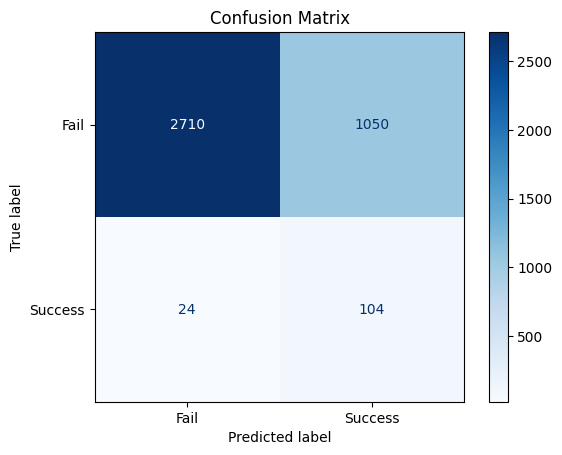

Precision: 0.0901
Recall:    0.8125
F1 Score:  0.1622


In [88]:
# === Test Evaluation ===
print("\nEvaluating on test set...")

# Load test data
X_test, y_test = torch.load("test_shots.pt", map_location="cpu")
X_test = X_test[:, -29:, :]
y_test_binary = (y_test == 0).long()  # goal → 1, others → 0

# Forward pass
model.eval()
all_test_preds = []
with torch.no_grad():
    for i in range(0, len(X_test), 128):
        xb = X_test[i:i+128].to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long().cpu()
        all_test_preds.extend(preds)

# Compute accuracy
y_test_binary = y_test_binary[:len(all_test_preds)]  # just in case
correct = (torch.tensor(all_test_preds) == y_test_binary).sum().item()
total = len(y_test_binary)
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_test_binary, all_test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fail", "Success"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

precision = precision_score(y_test_binary, all_test_preds)
recall = recall_score(y_test_binary, all_test_preds)
f1 = f1_score(y_test_binary, all_test_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

